# Klassifikationsmetriken in Python

Dieses Notebook erklärt wichtige Metriken für **binäre Klassifikation** und zeigt die **zugehörigen Python-Befehle**.

Behandelte Themen:
- Korrektklassifikationsrate (Accuracy)
- Konfusionsmatrix
- Prävalenz, Precision (Relevanz), Recall (Sensitivität) und Spezifität
- ROC-Kurve und AUC-Score

> Hinweis: Für ROC/AUC braucht man **Scores/Wahrscheinlichkeiten**, nicht nur harte Klassen (0/1).

In [45]:
# Installation (falls nötig) – in den meisten Jupyter-Umgebungen bereits vorhanden
# !pip install scikit-learn matplotlib pandas numpy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    roc_curve,
    roc_auc_score
)

np.random.seed(42)


## 1) Beispiel-Daten + Modell
Wir erzeugen ein kleines **synthetisches** binäres Klassifikationsproblem, trainieren ein Modell und erstellen Vorhersagen.

- `y_true`: echte Labels (0/1)
- `y_pred`: vorhergesagte Klassen (0/1)
- `y_score`: vorhergesagte Wahrscheinlichkeit/Score für Klasse 1

In [46]:
# Beispiel-Daten
X, y = make_classification(
    n_samples=1200,
    n_features=10,
    n_informative=5,
    n_redundant=2,
    weights=[0.70, 0.30],   # ungefähr 30% Positive (Prävalenz)
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# Modell: Logistic Regression (liefert Wahrscheinlichkeiten via predict_proba)
clf = LogisticRegression(max_iter=2000)
clf.fit(X_train, y_train)

# Vorhersagen
y_pred = clf.predict(X_test)                 # harte Klasse 0/1
y_score = clf.predict_proba(X_test)[:, 1]    # Score/Wahrscheinlichkeit für Klasse 1

pd.DataFrame({
    "y_true": y_test[:10],
    "y_pred": y_pred[:10],
    "y_score": np.round(y_score[:10], 4)
})


,y_true,y_pred,y_score
0,1,1,0.5965
1,0,0,0.0721
2,0,0,0.0045
3,0,0,0.1577
4,1,0,0.0469
5,0,0,0.0515
6,1,1,0.6398
7,0,1,0.6770
8,0,0,0.0978
9,0,1,0.5276


## 2) Korrektklassifikationsrate (Accuracy)
**Accuracy** misst den Anteil korrekt klassifizierter Beispiele:

$$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$$

Python-Befehl:
- `sklearn.metrics.accuracy_score(y_true, y_pred)`

In [47]:
acc = accuracy_score(y_test, y_pred)
acc


0.7666666666666667

## 3) Konfusionsmatrix
Die **Konfusionsmatrix** zeigt die vier Grundfälle:

- **TP** (True Positive): richtig positiv
- **TN** (True Negative): richtig negativ
- **FP** (False Positive): fälschlich positiv
- **FN** (False Negative): fälschlich negativ

Python-Befehle:
- `confusion_matrix(y_true, y_pred)`
- `ConfusionMatrixDisplay.from_predictions(y_true, y_pred)`

In [48]:
cm = confusion_matrix(y_test, y_pred)  # Standard: [[TN, FP], [FN, TP]]
cm


array([[188,  21],
       [ 49,  42]])

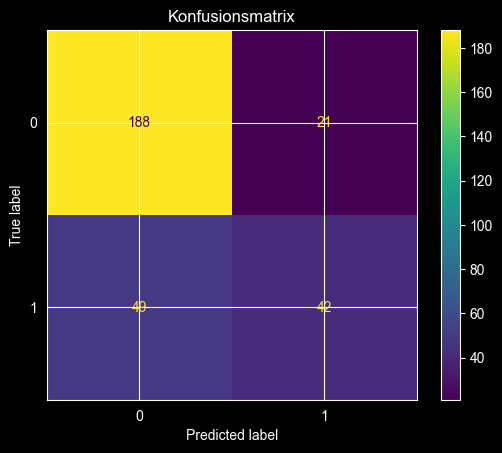

In [49]:
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Konfusionsmatrix")
plt.show()


### TP, TN, FP, FN aus der Matrix auslesen
Für binäre Klassifikation liefert scikit-learn die Matrix in dieser Form:

$$\begin{pmatrix}
TN & FP\\
FN & TP
\end{pmatrix}$$

In [50]:
tn, fp, fn, tp = cm.ravel()
tn, fp, fn, tp


(np.int64(188), np.int64(21), np.int64(49), np.int64(42))

## 4) Prävalenz, Precision, Recall, Spezifität
### 4.1 Prävalenz
**Prävalenz** ist der Anteil tatsächlicher Positiver in den Daten:

$$\text{Prävalenz} = \frac{P}{P + N} = \frac{TP + FN}{TP + TN + FP + FN}$$

In Python einfach über den Mittelwert von `y_true` (bei Labels 0/1):
- `prevalence = y_true.mean()`

### 4.2 Precision (Relevanz)
$$\text{Precision} = \frac{TP}{TP + FP}$$

Python:
- `precision_score(y_true, y_pred)`

### 4.3 Recall (Sensitivität)
$$\text{Recall} = \frac{TP}{TP + FN}$$

Python:
- `recall_score(y_true, y_pred)`

### 4.4 Spezifität (True Negative Rate)
$$\text{Spezifität} = \frac{TN}{TN + FP}$$

Spezifität gibt es in scikit-learn nicht als eigene Standardfunktion – man berechnet sie aus der Konfusionsmatrix.

In [51]:
prevalence = y_test.mean()

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)  # Sensitivität

specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan

pd.Series({
    "prevalence": prevalence,
    "accuracy": acc,
    "precision": precision,
    "recall (sensitivity)": recall,
    "specificity": specificity
})


prevalence              0.303333
accuracy                0.766667
precision               0.666667
recall (sensitivity)    0.461538
specificity             0.899522
dtype: float64

### Bonus: Alles als eigene Hilfsfunktion
Für Übungszwecke ist es oft praktisch, aus `y_true` und `y_pred` ein Metrik-Set zu berechnen.

In [52]:
def classification_metrics_binary(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    prevalence = np.mean(y_true)
    accuracy = (tp + tn) / (tp + tn + fp + fn)

    precision = tp / (tp + fp) if (tp + fp) > 0 else np.nan
    recall = tp / (tp + fn) if (tp + fn) > 0 else np.nan  # Sensitivität
    specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan

    return {
        "TN": tn, "FP": fp, "FN": fn, "TP": tp,
        "prevalence": prevalence,
        "accuracy": accuracy,
        "precision": precision,
        "recall (sensitivity)": recall,
        "specificity": specificity
    }

classification_metrics_binary(y_test, y_pred)


{'TN': np.int64(188),
 'FP': np.int64(21),
 'FN': np.int64(49),
 'TP': np.int64(42),
 'prevalence': np.float64(0.30333333333333334),
 'accuracy': np.float64(0.7666666666666667),
 'precision': np.float64(0.6666666666666666),
 'recall (sensitivity)': np.float64(0.46153846153846156),
 'specificity': np.float64(0.8995215311004785)}

## 5) ROC-Kurve und AUC
### 5.1 ROC-Kurve
Die ROC-Kurve stellt **True Positive Rate (Recall)** gegen **False Positive Rate** dar, während man den Schwellenwert variiert.

- TPR = Recall = TP/(TP+FN)
- FPR = FP/(FP+TN)

Python-Befehl:
- `roc_curve(y_true, y_score)`

Wichtig: `y_score` sind Wahrscheinlichkeiten/Scores für die positive Klasse, nicht `y_pred`.

### 5.2 AUC-Score
AUC ist die Fläche unter der ROC-Kurve:
- `roc_auc_score(y_true, y_score)`

In [53]:
fpr, tpr, thresholds = roc_curve(y_test, y_score)
auc = roc_auc_score(y_test, y_score)

auc


0.8057731741942268

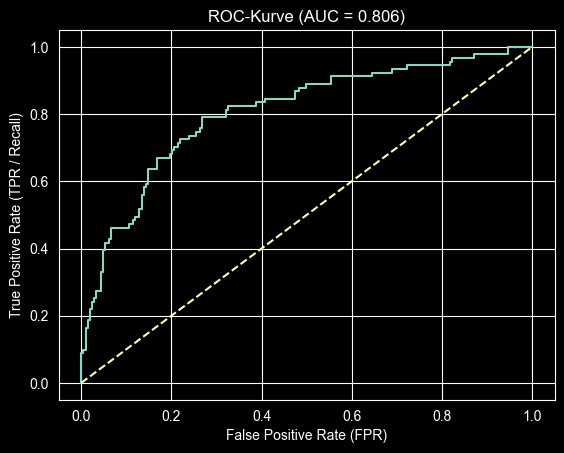

In [54]:
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")  # Zufalls-Klassifikator
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR / Recall)")
plt.title(f"ROC-Kurve (AUC = {auc:.3f})")
plt.grid(True)
plt.show()


### Schwellenwert (Threshold) ändern
Standardmäßig nutzt `predict()` bei vielen Modellen einen Schwellenwert von 0.5. Du kannst aber selbst Schwellenwerte testen.

Beispiel: Threshold = 0.3 → mehr Positive, oft höherer Recall, ggf. niedrigere Precision.

In [55]:
def predict_with_threshold(y_score, threshold=0.5):
    return (y_score >= threshold).astype(int)

for thr in [0.2, 0.3, 0.5, 0.7]:
    y_pred_thr = predict_with_threshold(y_score, thr)
    m = classification_metrics_binary(y_test, y_pred_thr)
    print(f"threshold={thr:0.1f} | precision={m['precision']:.3f} | recall={m['recall (sensitivity)']:.3f} | specificity={m['specificity']:.3f} | accuracy={m['accuracy']:.3f}")


threshold=0.2 | precision=0.484 | recall=0.824 | specificity=0.617 | accuracy=0.680
threshold=0.3 | precision=0.557 | recall=0.747 | specificity=0.742 | accuracy=0.743
threshold=0.5 | precision=0.667 | recall=0.462 | specificity=0.900 | accuracy=0.767
threshold=0.7 | precision=0.826 | recall=0.209 | specificity=0.981 | accuracy=0.747


## 6) Mini-Übungen
1. Ändere die Klassenverteilung (`weights` in `make_classification`) und beobachte, wie sich Prävalenz und Metriken verändern.
2. Probiere ein anderes Modell (z. B. `RandomForestClassifier`) aus.
3. Suche einen Threshold, der Recall ≥ 0.90 erreicht und notiere Precision/Spezifität.

Wenn du willst, kann ich dir auch ein zweites Notebook erstellen, das zusätzlich **F1-Score**, **Balanced Accuracy**, **PR-Kurve** und **Cross-Validation** zeigt.